**RNN**

![jupyter](./rnn.png)
![jupyter](./rnn_layer.png)
![jupyter](./rnn_layer2.png)
![jupyter](./sequence_to_vector.png)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_series(time,series,format='-',start=0,end=None):
    plt.plot(time[start:end],series[start:end],format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
def trend(time,slope=0):
    return slope*time


def seasonal_pattern(season_time):
    return np.where(season_time<0.4,
                    np.cos(season_time*2*np.pi),
                    1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time=((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set=windowed_dataset(x_train,window_size,batch_size=128,shuffle_buffer=shuffle_buffer_size)

model=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=-1),
                              input_shape=[None]),
    tf.keras.layers.SimpleRNN(40,return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*100.) # Lambda layer
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 162ms/step - loss: 195.6115 - mae: 196.0720
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 194.9002 - mae: 195.2834
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 193.7610 - mae: 194.0106
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 191.7773 - mae: 192.4087
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 189.9133 - mae: 190.5219
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 188.0889 - mae: 188.3526
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 185.2864 - mae: 185.8774
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 182.3494 - mae: 183.0458
Epoch 9/100
8/8 [==============================] - 0s 20ms/step - loss: 179.0416 - mae: 179.8092
Epoch 10/100
8/8 [==============================] - 0s 20ms/step - loss: 175.7152 - mae: 176.0968
Epoch 11/100
8/8 [==========

8/8 [==============================] - 0s 27ms/step - loss: 15.2128 - mae: 15.9710
Epoch 88/100
8/8 [==============================] - 0s 23ms/step - loss: 31.8952 - mae: 33.0969
Epoch 89/100
8/8 [==============================] - 0s 22ms/step - loss: 31.6946 - mae: 32.3630
Epoch 90/100
8/8 [==============================] - 0s 22ms/step - loss: 28.4646 - mae: 28.4642
Epoch 91/100
8/8 [==============================] - 0s 24ms/step - loss: 31.7741 - mae: 32.2768
Epoch 92/100
8/8 [==============================] - 0s 23ms/step - loss: 20.0242 - mae: 20.0311
Epoch 93/100
8/8 [==============================] - 0s 22ms/step - loss: 43.4157 - mae: 44.0535
Epoch 94/100
8/8 [==============================] - 0s 21ms/step - loss: 48.5292 - mae: 48.7538
Epoch 95/100
8/8 [==============================] - 0s 21ms/step - loss: 53.0546 - mae: 54.8162
Epoch 96/100
8/8 [==============================] - 0s 23ms/step - loss: 54.0201 - mae: 55.0968
Epoch 97/100
8/8 [==============================] - 0

(1e-08, 0.0001, 0.0, 30.0)

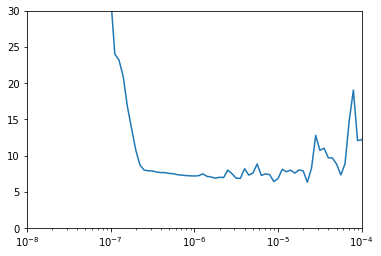

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 192ms/step - loss: 81.1158 - mae: 83.5783
Epoch 2/400
8/8 [==============================] - 0s 30ms/step - loss: 23.6082 - mae: 24.3853
Epoch 3/400
8/8 [==============================] - 0s 24ms/step - loss: 18.2199 - mae: 18.7075
Epoch 4/400
8/8 [==============================] - 0s 26ms/step - loss: 14.1505 - mae: 14.6785
Epoch 5/400
8/8 [==============================] - 0s 25ms/step - loss: 10.7215 - mae: 11.2668
Epoch 6/400
8/8 [==============================] - 0s 24ms/step - loss: 12.3846 - mae: 12.5480
Epoch 7/400
8/8 [==============================] - 0s 24ms/step - loss: 12.5813 - mae: 13.1282
Epoch 8/400
8/8 [==============================] - 0s 28ms/step - loss: 11.9381 - mae: 12.5351
Epoch 9/400
8/8 [==============================] - 0s 27ms/step - loss: 13.1706 - mae: 13.9180
Epoch 10/400
8/8 [==============================] - 0s 30ms/step - loss: 14.3160 - mae: 15.0105
Epoch 11/400
8/8 [==============================

8/8 [==============================] - 0s 31ms/step - loss: 5.8194 - mae: 6.2993
Epoch 88/400
8/8 [==============================] - 0s 31ms/step - loss: 5.0133 - mae: 5.5379
Epoch 89/400
8/8 [==============================] - 0s 31ms/step - loss: 4.4746 - mae: 4.9498
Epoch 90/400
8/8 [==============================] - 0s 35ms/step - loss: 5.4957 - mae: 6.0170
Epoch 91/400
8/8 [==============================] - 0s 34ms/step - loss: 5.4031 - mae: 5.8709
Epoch 92/400
8/8 [==============================] - 0s 35ms/step - loss: 5.2247 - mae: 5.7124
Epoch 93/400
8/8 [==============================] - 0s 34ms/step - loss: 4.7609 - mae: 5.2346
Epoch 94/400
8/8 [==============================] - 0s 36ms/step - loss: 4.4427 - mae: 4.8971
Epoch 95/400
8/8 [==============================] - 0s 36ms/step - loss: 5.0349 - mae: 5.4956
Epoch 96/400
8/8 [==============================] - 0s 37ms/step - loss: 5.0416 - mae: 5.5624
Epoch 97/400
8/8 [==============================] - 0s 39ms/step - loss: 

8/8 [==============================] - 0s 40ms/step - loss: 5.0991 - mae: 5.5749
Epoch 174/400
8/8 [==============================] - 0s 39ms/step - loss: 4.7907 - mae: 5.2501
Epoch 175/400
8/8 [==============================] - 0s 39ms/step - loss: 4.8403 - mae: 5.3520
Epoch 176/400
8/8 [==============================] - 0s 40ms/step - loss: 4.9624 - mae: 5.4227
Epoch 177/400
8/8 [==============================] - 0s 41ms/step - loss: 4.7168 - mae: 5.1941
Epoch 178/400
8/8 [==============================] - 0s 39ms/step - loss: 4.5443 - mae: 5.0219
Epoch 179/400
8/8 [==============================] - 0s 38ms/step - loss: 4.8103 - mae: 5.3132
Epoch 180/400
8/8 [==============================] - 0s 37ms/step - loss: 6.6452 - mae: 7.1721
Epoch 181/400
8/8 [==============================] - 0s 38ms/step - loss: 6.8490 - mae: 7.3894
Epoch 182/400
8/8 [==============================] - 0s 36ms/step - loss: 7.4758 - mae: 7.9227
Epoch 183/400
8/8 [==============================] - 0s 35ms/ste

8/8 [==============================] - 0s 31ms/step - loss: 4.2246 - mae: 4.7082
Epoch 260/400
8/8 [==============================] - 0s 29ms/step - loss: 4.1858 - mae: 4.6565
Epoch 261/400
8/8 [==============================] - 0s 29ms/step - loss: 4.1761 - mae: 4.6598
Epoch 262/400
8/8 [==============================] - 0s 29ms/step - loss: 4.3102 - mae: 4.7282
Epoch 263/400
8/8 [==============================] - 0s 29ms/step - loss: 4.0627 - mae: 4.5431
Epoch 264/400
8/8 [==============================] - 0s 31ms/step - loss: 4.6890 - mae: 5.1682
Epoch 265/400
8/8 [==============================] - 0s 32ms/step - loss: 4.8632 - mae: 5.3094
Epoch 266/400
8/8 [==============================] - 0s 31ms/step - loss: 4.7634 - mae: 5.2549
Epoch 267/400
8/8 [==============================] - 0s 31ms/step - loss: 4.5035 - mae: 5.0236
Epoch 268/400
8/8 [==============================] - 0s 32ms/step - loss: 4.2637 - mae: 4.7617
Epoch 269/400
8/8 [==============================] - 0s 30ms/ste

8/8 [==============================] - 0s 36ms/step - loss: 4.5427 - mae: 4.9818
Epoch 346/400
8/8 [==============================] - 0s 36ms/step - loss: 5.1286 - mae: 5.5794
Epoch 347/400
8/8 [==============================] - 0s 36ms/step - loss: 4.8280 - mae: 5.2195
Epoch 348/400
8/8 [==============================] - 0s 36ms/step - loss: 5.3152 - mae: 5.7961
Epoch 349/400
8/8 [==============================] - 0s 36ms/step - loss: 5.0576 - mae: 5.5696
Epoch 350/400
8/8 [==============================] - 0s 36ms/step - loss: 4.1754 - mae: 4.6666
Epoch 351/400
8/8 [==============================] - 0s 35ms/step - loss: 4.8335 - mae: 5.2794
Epoch 352/400
8/8 [==============================] - 0s 35ms/step - loss: 4.4100 - mae: 4.8842
Epoch 353/400
8/8 [==============================] - 0s 39ms/step - loss: 4.1930 - mae: 4.6670
Epoch 354/400
8/8 [==============================] - 0s 37ms/step - loss: 4.3967 - mae: 4.8157
Epoch 355/400
8/8 [==============================] - 0s 36ms/ste

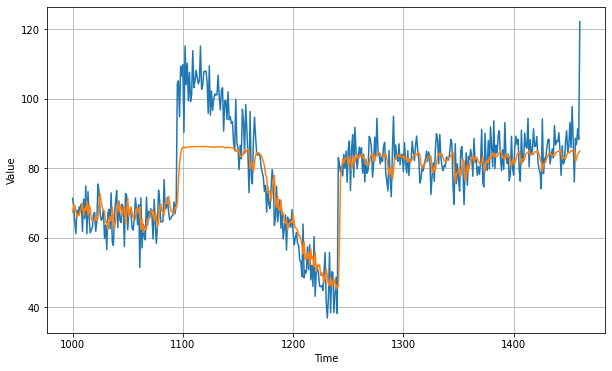

In [7]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.0376225

<Figure size 432x288 with 0 Axes>

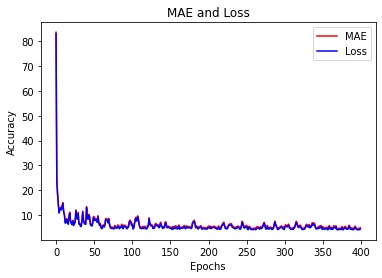

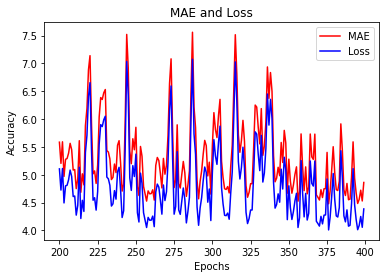

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()